# Определение возраста покупателей

# Описание проекта

Для сетевого супермаркета «Хлеб-Соль» нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека на основании набора  фотографий людей с указанием возраста.
Супермаркет планирует использовать для 2 основных задач:
1. предложение товаров людям с учетом их возрасьтной категории;
2. проверка кассиров на предмет продажи алкоголя только лицам, достигшим возраста 18 лет.

## Исследовательский анализ данных

Проведем исследовательский анализ набора данных

1.1. Загрузим необходимые библиотеки

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

1.2. Загрузим данные и фотографии:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


1.3. Напечатаем 16 фотографий

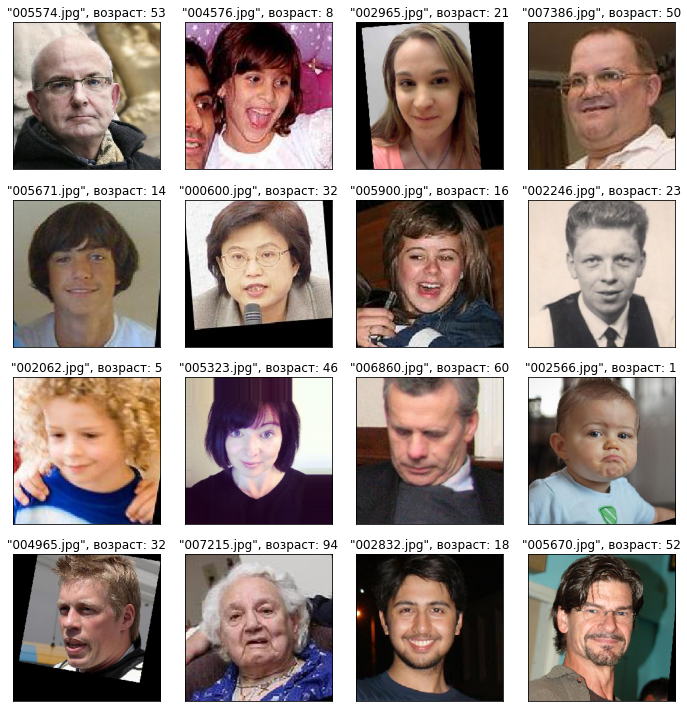

In [40]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1) 
    plt.imshow(train_gen_flow[0][0][i]) # i-тая картинка первого батча
    plt.title(
        f'"{train_gen_flow.filenames[train_gen_flow.index_array[i]]}", возраст: {train_gen_flow[0][1][i]}'
    )
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

1.4. Рассмотрим поподробнее имеющиеся в нашем распоряжении данные

In [41]:
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [42]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [43]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [46]:
labels.isna().sum() #проверим пропуски

file_name    0
real_age     0
dtype: int64

In [47]:
 labels.duplicated().sum()  #проверка явных дубликатов

0

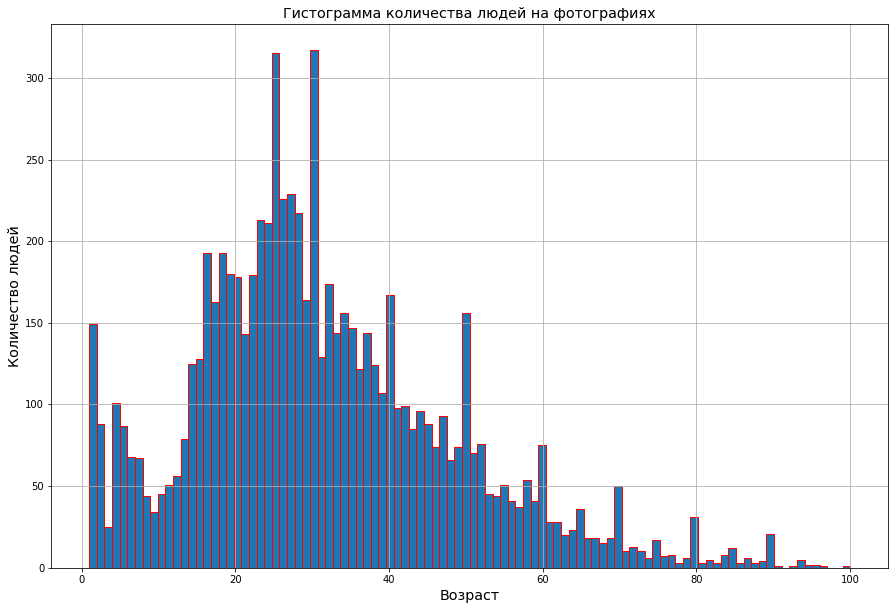

In [59]:
plt.figure(figsize=(15,10))
labels['real_age'].plot.hist(bins=100, grid=True, edgecolor='red')
plt.title('Гистограмма количества людей на фотографиях', fontsize='x-large')
plt.xlabel('Возраст', fontsize='x-large')
plt.ylabel('Количество людей', fontsize='x-large')
plt.show()

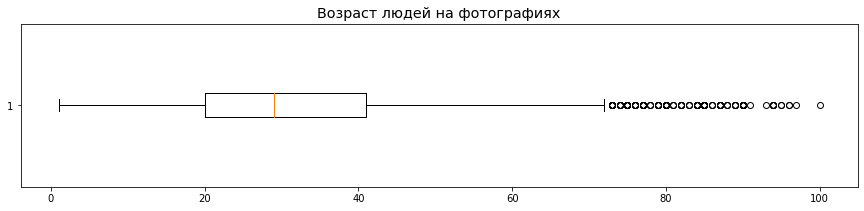

In [55]:
# построим диаграмму размаха 
plt.figure(figsize=(15,3))
plt.title('Возраст людей на фотографиях', fontsize='x-large')
plt.boxplot(labels['real_age'], vert=False)
plt.show()

большинство фотографий людей возрастом от 20 до 40, количество выбросов небольшое

# Вывод:

1. Пропусков и дубликатов нет;
2. В датасете есть, как цветные, так и черно-белые фотографии;
3. Наиболее широко на фотографиях представлены люди возрастом от 20 до 40 лет;
4. Люди до года не представлены на фотографиях, люди после 60 лет представлены на фото в очень малом количестве.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

def load_train(path):
    labels = pd.read_csv(os.path.join(path,'labels.csv'))
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=os.path.join(path, 'final_files'),
            horizontal_flip=True,
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1. / 255)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_datagen_flow


def create_model(input_shape):
    optimazer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse',
                  optimizer=optimazer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, epochs=epochs)

    return model

Epoch 1/5
2023-07-20 20:13:38.145186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-20 20:13:38.450380: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 64s - loss: 229.1003 - mae: 10.8921 - val_loss: 917.6206 - val_mae: 25.4741
Epoch 2/5
178/178 - 39s - loss: 59.2123 - mae: 5.8669 - val_loss: 785.6954 - val_mae: 23.0206
Epoch 3/5
178/178 - 39s - loss: 29.5102 - mae: 4.1990 - val_loss: 371.5631 - val_mae: 14.4301
Epoch 4/5
178/178 - 39s - loss: 19.2020 - mae: 3.3658 - val_loss: 107.3691 - val_mae: 7.8378
Epoch 5/5
178/178 - 39s - loss: 15.1098 - mae: 3.0100 - val_loss: 80.5074 - val_mae: 6.9410
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 80.5074 - mae: 6.9410
Test MAE: 6.9410

## Анализ обученной модели (общий вывод)

Мы решали задачу от супермаркета по построению модели, определяющей приблизительный возраст человека по фотографии. Модель планируется использовать для 2 основных задач:
1. предложение товаров людям с учетом их возрастной категории;
2. проверка кассиров на предмет продажи алкоголя только лицам, достигшим возраста 18 лет.

В нашем распоряжении был датасет из 7591 размеченных фотографий лица людей разного возраста. На большей части фотографий - люди от 20 до 40 лет.

Мы воспользовались моделью с ResNet50, предобученной на ImageNet c слоями GlobalAveragePooling2D — пулинг с окном во весь тензор и Dense - полносвязный слой для классификации, также используем оптимайзер Adam с lr=0.0001, loss функция - mse, а метрика - mae, число эпох - 5.

Точность модели на тестовой выборке - 6.9410.
Соответственно наша модель определяет возраст с точностью +/- 7 лет.

Для решения первой задачи супермаркета наша модель подойдет.
Для решения второй задачи супермаркета наша модель НЕ подойдет, так как тут важен каждый год.

Для того, чтобы попробовать увеличить точность модели, надо получить больше фотографий людей возрастом  до 20 лет для того, чтобы эта возрастная категория людей была более широко представлена в датасете, на котором обучается наша модель. 
